In [4]:
%reload_ext autoreload
%autoreload 2

import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from sklearn.cluster import KMeans
import statsmodels.api as sm
from lib import utils


mpl.rcParams['font.family'] = 'times new roman'
mpl.rcParams['font.size'] = 16

In [5]:
df = pd.read_csv('valid_sequence_data.csv',index_col=0)

In [6]:
# If data is clustered to three groups, one of these groups only has 9 subjects
# This explains why we only cluster subjects to two groups 
df_time_pivot_2 = df.pivot(index='worker_id', columns='reward', values='value_surplus')
kmeans = KMeans(n_clusters=3,random_state=42)
kmeans.fit(df_time_pivot_2.values)
print('Number of participants in each cluster:',np.bincount(kmeans.labels_))

Number of participants in each cluster: [105  55   1]


In [7]:
# Spearman rank-order correlation
# the entire sample
print(stats.spearmanr(df['value_surplus'],df['front_amount']))

# cluster 1
print(stats.spearmanr(df[df['label_kmeans'] == 0]['value_surplus'],
                df[df['label_kmeans'] == 0]['front_amount']))

# cluster 2
print(stats.spearmanr(df[df['label_kmeans'] == 1]['value_surplus'],
                    df[df['label_kmeans'] == 1]['front_amount']))

SignificanceResult(statistic=-0.04871921859566945, pvalue=0.020717183445793052)
SignificanceResult(statistic=-0.01543062586818839, pvalue=0.5563145093935986)
SignificanceResult(statistic=-0.1892458603593054, pvalue=7.190225038954018e-08)


In [8]:
df['front_amount_6m'] = df['front_amount'] * (df['seq_length'] == '6 months')
df['front_amount_12m'] = df['front_amount'] * (df['seq_length'] == '12 months')
df['front_amount_6m_0'] = df['front_amount_6m']  * (df['label_kmeans'] == 0)
df['front_amount_6m_1'] = df['front_amount_6m']  * (df['label_kmeans'] == 1)
df['front_amount_12m_0'] = df['front_amount_12m']  * (df['label_kmeans'] == 0)
df['front_amount_12m_1'] = df['front_amount_12m']  * (df['label_kmeans'] == 1)


df_dummy = pd.concat([df,pd.get_dummies(df['worker_id'], prefix='worker_id')],axis=1)
df_filtered = utils.rule_out_outlier(df_dummy,col_name='value_surplus')

reg_cols_baseline = ['front_amount_6m','front_amount_12m','choice_peli']
reg_cols_label = ['front_amount_6m_0','front_amount_12m_0','front_amount_6m_1','front_amount_12m_1','choice_peli']
reg_cols_dummy = reg_cols_baseline + [col for col in df_dummy.columns if col.startswith('worker_id_')]
reg_cols_dummy_2 = reg_cols_label + [col for col in df_dummy.columns if col.startswith('worker_id_')]


formula_pool_1 = 'value_surplus ~ front_amount_6m + front_amount_12m + choice_peli'
model_ols_pool_1 = sm.OLS.from_formula(formula_pool_1,data=df_filtered).fit(
                                        cov_type='cluster',cov_kwds={'groups': df_filtered['worker_id']})

Number of outliers (lower and upper): [5, 7]


In [9]:
formula_pool_2 = 'value_surplus ~ front_amount_6m_0 + front_amount_12m_0 + front_amount_6m_1 + front_amount_12m_1 + choice_peli'
model_ols_pool_2 = sm.OLS.from_formula(formula_pool_2,data=df_filtered).fit(
                                        cov_type='cluster',cov_kwds={'groups': df_filtered['worker_id']})

In [10]:
formula_fe = formula_pool_1 + '+C(worker_id)'
model_ols_fe = sm.OLS.from_formula(formula_fe,data=df_filtered).fit(
                                        cov_type='cluster',cov_kwds={'groups': df_filtered['worker_id']})

pd.concat([model_ols_fe.params[reg_cols_baseline].rename('coef'),
           model_ols_fe.pvalues[reg_cols_baseline].rename('pvalues'),
           model_ols_fe.conf_int().loc[reg_cols_baseline].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m,-0.005829,0.005440,-0.00994,-0.001719
front_amount_12m,-0.005720,0.008665,-0.00999,-0.001449
choice_peli,8.796278,0.000000,8.76846,8.824097


In [11]:
formula_fe_2 = formula_pool_2 + '+C(worker_id)'
model_ols_fe_2 = sm.OLS.from_formula(formula_fe_2,data=df_filtered).fit(
                                        cov_type='cluster',cov_kwds={'groups': df_filtered['worker_id']})

pd.concat([model_ols_fe_2.params[reg_cols_label].rename('coef'),
           model_ols_fe_2.pvalues[reg_cols_label].rename('pvalues'),
           model_ols_fe_2.conf_int().loc[reg_cols_label].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m_0,0.002182,2.327582e-01,-0.001402,0.005765
front_amount_12m_0,0.003181,1.091919e-01,-0.000711,0.007074
front_amount_6m_1,-0.020469,1.150768e-06,-0.028718,-0.012221
front_amount_12m_1,-0.021932,1.162556e-07,-0.030043,-0.013820
choice_peli,6.520186,3.281062e-62,5.752435,7.287937


In [12]:
y = df['value_surplus']
X = sm.add_constant(df[reg_cols_baseline]).astype(float)
model_rlm_pool_1 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())
model_rlm_pool_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Robust linear Model Regression Results                                            
==============================================================================================================================
Dep. Variable:                                                          value_surplus   No. Observations:                 2254
Model:                                                                            RLM   Df Residuals:                     2250
Method:                                                                          IRLS   Df Model:                            3
Norm:                                                                          HuberT                                         
Scale Est.:        <statsmodels.robust.scale.HuberScale object at 0x000001D928C6B690>                                         
Cov Type:                                                                          H1                                         
Date:                                                                Sun, 11 Feb 2024                                         
Time:                                                                        02:35:28                                         
No. Iterations:                                                                    12                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               55.4254      0.970     57.118      0.000      53.523      57.327
front_amount_6m     -0.0055      0.003     -2.137      0.033      -0.011      -0.000
front_amount_12m    -0.0068      0.003     -2.632      0.008      -0.012      -0.002
choice_peli         -1.3322      0.865     -1.540      0.124      -3.027       0.363
====================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [13]:
y = df['value_surplus']
X = sm.add_constant(df[reg_cols_label]).astype(float)
model_rlm_pool_2 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())
model_rlm_pool_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Robust linear Model Regression Results                                            
==============================================================================================================================
Dep. Variable:                                                          value_surplus   No. Observations:                 2254
Model:                                                                            RLM   Df Residuals:                     2248
Method:                                                                          IRLS   Df Model:                            5
Norm:                                                                          HuberT                                         
Scale Est.:        <statsmodels.robust.scale.HuberScale object at 0x000001D928F82DD0>                                         
Cov Type:                                                                          H1                                         
Date:                                                                Sun, 11 Feb 2024                                         
Time:                                                                        02:35:29                                         
No. Iterations:                                                                    16                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 56.2852      0.732     76.858      0.000      54.850      57.720
front_amount_6m_0      0.0158      0.002      7.321      0.000       0.012       0.020
front_amount_12m_0     0.0156      0.002      7.202      0.000       0.011       0.020
front_amount_6m_1     -0.0601      0.003    -23.150      0.000      -0.065      -0.055
front_amount_12m_1    -0.0650      0.003    -25.056      0.000      -0.070      -0.060
choice_peli           -1.5245      0.653     -2.335      0.020      -2.804      -0.245
======================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [14]:
y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy]).astype(float)
model_rlm_fe = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())

pd.concat([model_rlm_fe.params[reg_cols_baseline].rename('coef'),
           model_rlm_fe.pvalues[reg_cols_baseline].rename('pvalues'),
           model_rlm_fe.conf_int().loc[reg_cols_baseline].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m,-0.005190,6.105280e-07,-0.007230,-0.003151
front_amount_12m,-0.006747,8.923453e-11,-0.008787,-0.004708
choice_peli,1.431461,1.474419e-05,0.783884,2.079038


In [15]:
y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy_2]).astype(float)
model_rlm_fe_2 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())

pd.concat([model_rlm_fe_2.params[reg_cols_label].rename('coef'),
           model_rlm_fe_2.pvalues[reg_cols_label].rename('pvalues'),
           model_rlm_fe_2.conf_int().loc[reg_cols_label].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m_0,0.000134,9.155041e-01,-0.002335,0.002603
front_amount_12m_0,-0.000072,9.546211e-01,-0.002541,0.002397
front_amount_6m_1,-0.017829,1.093544e-25,-0.021164,-0.014494
front_amount_12m_1,-0.022489,7.050665e-40,-0.025824,-0.019154
choice_peli,1.438963,7.660842e-06,0.808647,2.069279


NormaltestResult(statistic=1432.9044175816362, pvalue=0.0)


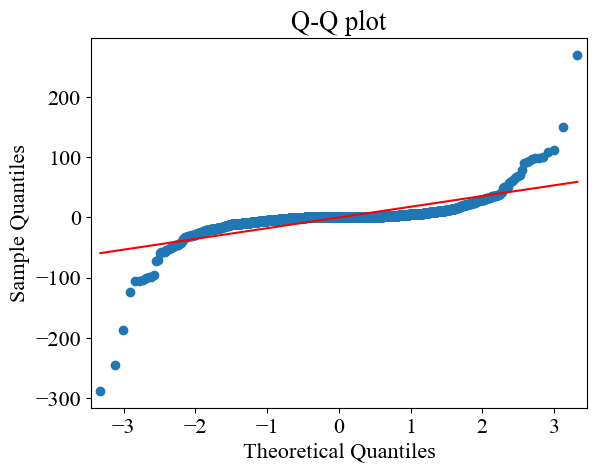

In [16]:
pplot = sm.ProbPlot(model_rlm_fe_2.resid)
fig = pplot.qqplot(line='s')
plt.title('Q-Q plot')
print(stats.normaltest(model_rlm_fe_2.resid))

In [17]:
# save regression results
model_results = {'ols_pool_baseline':utils.get_reg_result(model_ols_pool_1,reg_cols_baseline),
                 'ols_pool_label':utils.get_reg_result(model_ols_pool_2,reg_cols_label),
                 'ols_fe_baseline':utils.get_reg_result(model_ols_fe,reg_cols_baseline),
                 'ols_fe_label':utils.get_reg_result(model_ols_fe_2,reg_cols_label),
                 'rlm_pool_baseline':utils.get_reg_result(model_rlm_pool_1,reg_cols_baseline),
                 'rlm_pool_label':utils.get_reg_result(model_rlm_pool_2,reg_cols_label),
                 'rlm_fe_baseline':utils.get_reg_result(model_rlm_fe,reg_cols_baseline),
                 'rlm_fe_label':utils.get_reg_result(model_rlm_fe_2,reg_cols_label)
                 }

with open('model_reg_result_k.json', "w") as f:
    json.dump(model_results, f)

In [18]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_pool_1,param_names=reg_cols_baseline,n_bootstrap=1000)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_pool_baseline_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [00:30<00:00, 33.07it/s]


In [19]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_pool_2,param_names=reg_cols_label,n_bootstrap=1000)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_pool_label_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [00:31<00:00, 31.33it/s]


In [20]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_fe,param_names=reg_cols_baseline,n_bootstrap=1000,fe=True)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_fe_baseline_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [40:04<00:00,  2.40s/it] 


In [21]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_fe_2,param_names=reg_cols_label,n_bootstrap=1000,fe=True)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_fe_label_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [31:29<00:00,  1.89s/it]
